In [2]:
from PIL import Image
from PIL.TiffTags import TAGS
import skimage as sk_image
import cv2
import numpy as np
import os, glob, re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import skimage.external.tifffile as sktiff
from pprint import pprint
import seaborn as sns
import json
import pandas as pd
import collections
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import OrderedDict
# import czifile
plt.rcParams['figure.dpi'] = 175

In [20]:
# path_dapi_tiffs = '/QRISdata/Q1206/Slidescanner_files/20191205/single channel images/'
# path_dapi_tiffs = '/QRISdata/Q1206/Slidescanner_files/20191205/'
path_dapi_tiffs = '/QRISdata/Q1851/Minh/RNAScope/2020_05_05_R1_DAPI_TIFF/'
path_all_channel_tiff = '/QRISdata/Q1851/Minh/RNAScope/2020_05_05_R1_THY1_IL34_CSFR1_DAPI_TIFF/'
qupath_output = '/QRISdata/Q1851/Minh/RNAScope/QuPath_project_1/'

cy7_path = 'Cy7'
cy5_path = 'Cy5'
cy3_path = 'Cy3'
fitc_path = 'FITC'
dapi_path = 'DAPI'
scene1_ref = '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif'
scene2_ref = '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif'
scene3_ref = '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif'
scene4_ref = '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif'
all_channel_ref = '2020_05_05_R1_THY1_IL34_CSFR1_DAPI_TIFF_s1z2c1-4.tif'
# scene1_ref = 'BCC_R1_skin1.tif'
# scene2_ref = 'BCC_R1_skin2.tif'
# scene3_ref = 'BCC_R1_skin3.tif'
# scene4_ref = 'BCC_R1_skin4.tif'
# scene1_ref = 'skin1_R1_5channels.tif'
# scene2_ref = 'skin2_R1_5channels.tif'
# scene3_ref = 'skin3_R1_5channels.tif'
# scene4_ref = 'skin4_R1_5channels.tif'
# original_czi1_size = (18468, 49329)
# original_czi2_size = (14778, 38361)
# original_czi3_size = (12890, 20217)
# original_czi4_size = (14870, 34710)
original_czi1_size = (54513, 23814)
original_czi2_size = (14778, 38361)
original_czi3_size = (12890, 20217)
original_czi4_size = (14870, 34710)
big_window = 0.1
medium_window = 0.25*0.1
small_window = 0.5*medium_window

In [18]:
def get_files_in_directory(directory, postfix=""):
    fileNames = [s for s in os.listdir(directory) if not os.path.isdir(os.path.join(directory, s))]
    if not postfix or postfix == "":
        return sorted(fileNames)
    else:
        return sorted([s for s in fileNames if s.lower().endswith(postfix)])
    
def get_files_in_dir_recursively(directory, postfix='json'):
    files = [file for file in glob.glob(os.path.join(directory, '**/*.{0}'.format(postfix)), recursive=True)]
    return files

def get_subdirectories_in_directory(directory, postfix=""):
    dir_names = [s for s in os.listdir(directory) if os.path.isdir(os.path.join(directory, s))]
    return sorted(dir_names)

def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)


def convert_original2scaled(x_coord, y_coord, scaled_size, original_size=original_czi1_size, exclude_rate_h=1.0, exclude_rate_w=1.0):
    return int(x_coord*scaled_size[0]/(original_size[0]*exclude_rate_w)), int(y_coord*scaled_size[1]/(original_size[1]*exclude_rate_h))


def list_to_int(list1D):
    return [int(float(x)) for x in list1D]

def draw_rectangles(img, rects, color=(0, 255, 255), thickness=7):
    clone_image = img.copy()
    for rect in rects:
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, pt1, pt2, color, thickness, cv2.FILLED)
    return clone_image

def get_xy_from_fn(fn):
    results = re.findall('x(\d+)_y(\d+)', fn)
    if len(results) == 1:
        x_coord, y_coord = results[0]
        x_coord, y_coord = int(x_coord), int(y_coord)
        return x_coord, y_coord, None
    else:
        x_coord, y_coord = results[-1]
        x_coord, y_coord = int(x_coord), int(y_coord)
        return x_coord, y_coord, [list_to_int(element) for element in results[:-1]]

def substite_file_name(file_name, pattern = 'Cy7',sub_string='Cy5'):
    output = re.sub(pattern, sub_string, file_name)
    return output 

/QRISdata/Q1851/Minh/RNAScope/2020_05_05_R1_DAPI_TIFF/2020_05_05_R1_DAPI_TIFF_s1z1c4.tif
(17989, 7859, 3)


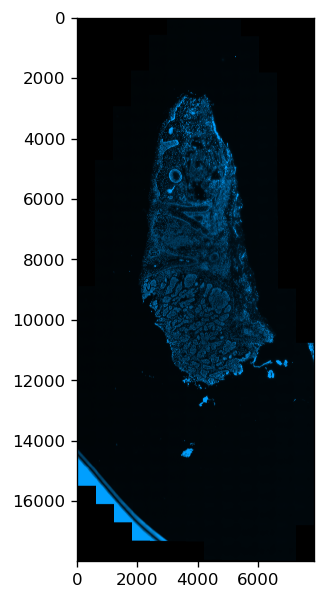

In [6]:
print(os.path.join(path_dapi_tiffs, scene1_ref))
img_dapi_origin = cv2.cvtColor(cv2.imread(os.path.join(path_dapi_tiffs, scene2_ref)), cv2.COLOR_BGR2RGB)
print(img_dapi_origin.shape)
# (582, 1736, 3)
img_dapi = np.zeros_like(img_dapi_origin)
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.imshow(img_dapi_origin, vmax=255, vmin=0)

/QRISdata/Q1851/Minh/RNAScope/2020_05_05_R1_THY1_IL34_CSFR1_DAPI_TIFF/2020_05_05_R1_THY1_IL34_CSFR1_DAPI_TIFF_s1z2c1-4.tif
(17989, 7859, 3)


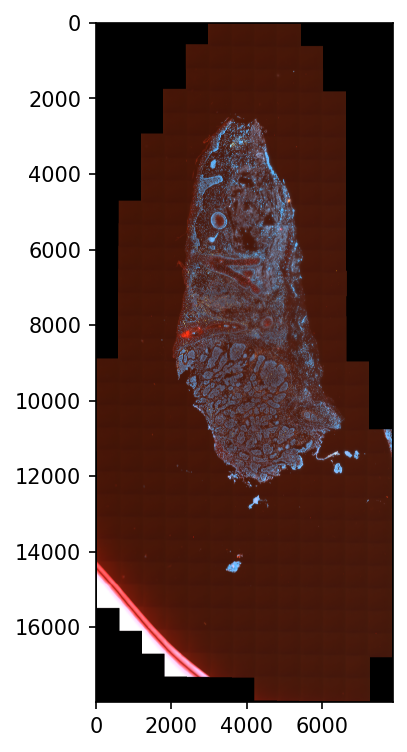

In [38]:
print(os.path.join(path_all_channel_tiff, all_channel_ref))
img_all_origin = cv2.cvtColor(cv2.imread(os.path.join(path_all_channel_tiff, all_channel_ref)), cv2.COLOR_BGR2RGB)
print(img_all_origin.shape)
# (582, 1736, 3)
# img_dapi = np.zeros_like(img_dapi_origin)
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.imshow(img_all_origin, vmax=255, vmin=0)
plt.imsave('all_channels_ref.jpg',img_all_origin)

In [7]:
scene_output_dir = os.path.join(qupath_output, 'Scene_1')
list_output_files = get_files_in_dir_recursively(scene_output_dir)
print(len(list_output_files))
list_output_files = np.array(list_output_files)

6224


In [29]:
all_rects = list()
recorded_parent_boxes = list()
for fn in list_output_files:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
#             pass
            for index, parent_annot in enumerate(parent_annots):
                if parent_annot not in recorded_parent_boxes:
                    x_par, y_par = parent_annot
                    annot_x, annot_y = convert_original2scaled(x_par, 
                                                               y_par, 
                                                               (img_dapi.shape[0], img_dapi.shape[1]),
                                                               original_czi1_size)
                    if index == 0:
                        rect = [annot_x, 
                                annot_y, 
                                annot_x+int(big_window*img_dapi.shape[1]),
                                annot_y+int(big_window*img_dapi.shape[0]*0.8)]
                        all_rects.append(rect)
                        recorded_parent_boxes.append(parent_annot)
                    elif index == 1:
                        rect = [annot_x, 
                                annot_y, 
                                annot_x+int(medium_window*img_dapi.shape[1]),
                                annot_y+int(medium_window*img_dapi.shape[0]*0.8)]
                        all_rects.append(rect)
                        recorded_parent_boxes.append(parent_annot)
            annot_x, annot_y = convert_original2scaled(x_coord, 
                                                       y_coord, 
                                                       (img_dapi.shape[0], img_dapi.shape[1]), 
                                                       original_czi1_size)
            if len(parent_annots) == 1:
                ratio = medium_window
            else:
                ratio = small_window
                
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(ratio*img_dapi.shape[1]),
                    annot_y+int(ratio*img_dapi.shape[0]*0.8)]
            all_rects.append(rect)
        else:
            annot_x, annot_y = convert_original2scaled(x_coord, 
                                                       y_coord, 
                                                       (img_dapi.shape[0], img_dapi.shape[1]), 
                                                       original_czi1_size)
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(big_window*img_dapi.shape[1]),
                    annot_y+int(big_window*img_dapi.shape[0]*0.8)]
            all_rects.append(rect)



1989


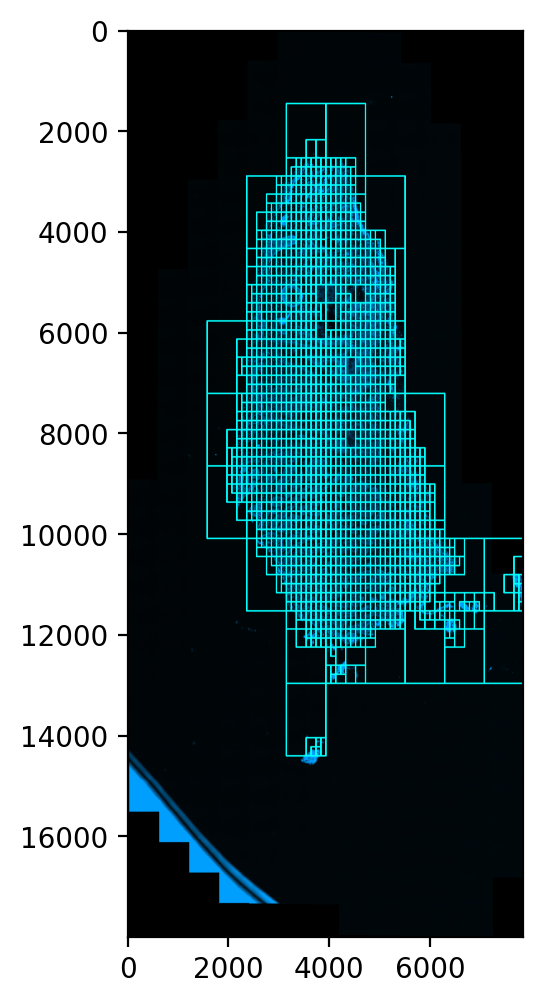

In [30]:
demo_image = draw_rectangles(img_dapi_origin, all_rects, thickness=30)
print(len(all_rects))
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(demo_image, vmax=255, vmin=0)
plt.savefig('All_annotation_visualize')

In [31]:
def parse_measurement_string(measurement_string):
    result = re.sub(r"\[|\]", '',measurement_string)
    elements = result.split(', ')
    data_dict = collections.OrderedDict()
    for element in elements:
        float_value = re.findall("-?\d+\.\d+|NaN", element)
        if len(float_value) == 0:
            key_value, name = re.split(' ', element)
            data_dict[key_value[:-1]] = name
        else:
            exponents = re.findall("([eE][-+]?[0-9]+)", element)
            if len(exponents) > 0:
#                 print(str(float_value[0])+str(exponents[0]))
                key_value = re.sub(str(float_value[0])+str(exponents[0]), '', element)
                data_dict[key_value[:-2]] = float(str(float_value[0])+str(exponents[0]))
            else:
                key_value = re.sub(float_value[0], '', element)
                if float_value[0] == 'NaN':
                    data_dict[key_value[:-2]] = float(0.0)
                else:
                    data_dict[key_value[:-2]] = float(float_value[0])

    return pd.DataFrame(data_dict, index=[0]), data_dict.keys()

def convert_json2dataframe(fn, col_names = None):
    with open(fn) as json_file:
        json_values = json.load(json_file)
    if len(json_values) != 0:
        measure_values, row_name = parse_measurement_string(json_values[0])
        for element in json_values[1:]:
            frame, keys = parse_measurement_string(element)
            measure_values = measure_values.append(frame, ignore_index=True)
        return measure_values
    else:
        if col_names == None:
            raise Exception("No value found", fn)
        else:
            measure_values, row_name = parse_measurement_string(col_names)
            return measure_values
            

def draw_rectangles_heat(img, rects, colors):
    clone_image = img.copy()
    for index, rect in enumerate(rects):
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, pt1, pt2, colors[index], cv2.FILLED)
    return clone_image

def normalize_score_by_rect(score, rect):
    area = abs(rect[2] - rect[0])*abs(rect[3]-rect[1])
    return score


def map_heat_values2colors(values):
    colors = list()
#     count = 0
    sorted_values = np.sort(values, kind='mergesort')
    set_box_scores = list(OrderedDict.fromkeys(sorted_values).keys())
    heat_colors_range = sns.color_palette('viridis', len(set_box_scores))
    for value in values:
        raw_color = heat_colors_range[set_box_scores.index(value)]
        colors.append(raw_color)
#         if set_box_scores.index(value) > 49:
#             count+= 1
#     print(count)
    return np.array(colors)

def draw_rectangles_heat(img, rects, colors, scores):
    clone_image = img.copy()
    for index, rect in enumerate(rects):
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, pt1, pt2, colors[index], cv2.FILLED)
#         print(scores[index])
#         cv2.putText(clone_image, str(scores[index]), tuple((pt1[0], pt1[1])), cv2.FONT_HERSHEY_SIMPLEX, 
#                     50, color=(255,255,255))
    return clone_image


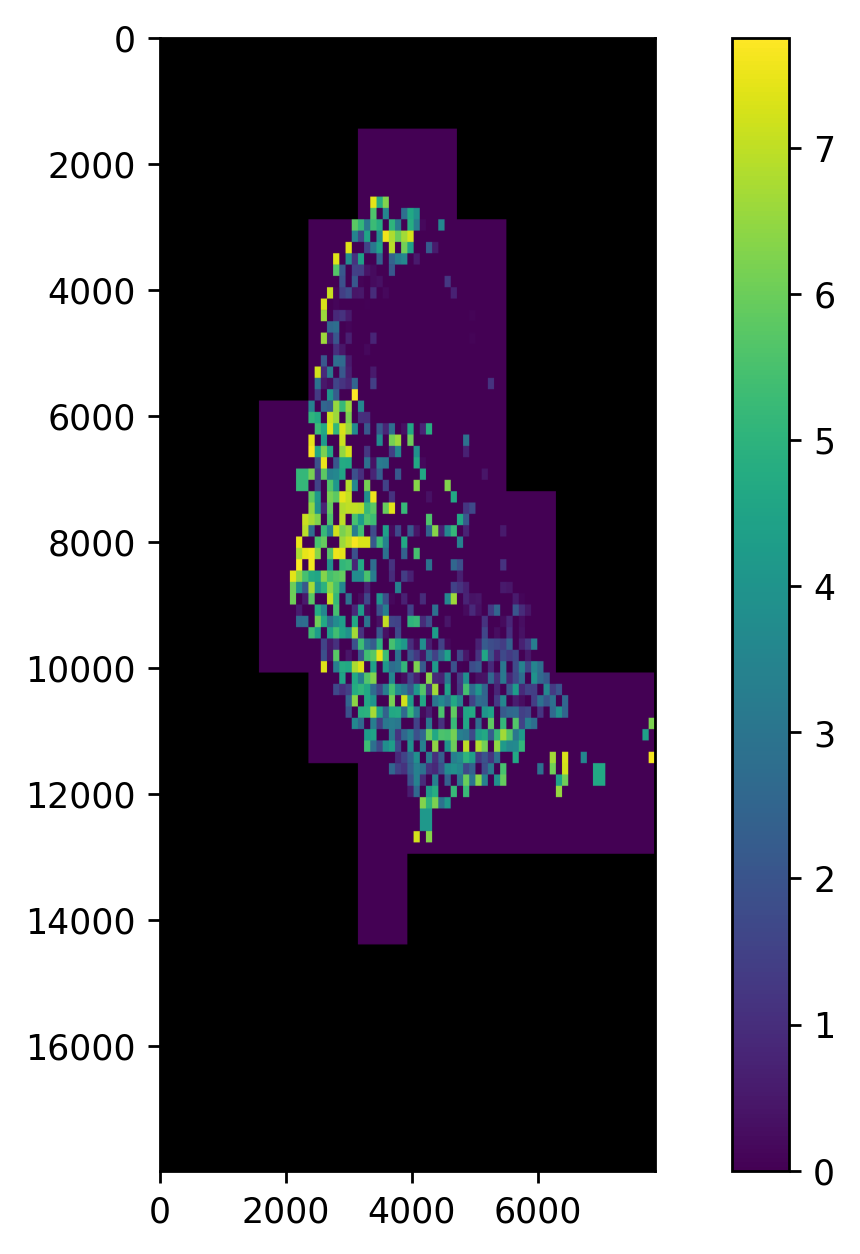

In [35]:
def collocalize_score(fn):
    equivalent_cy7_fn = substite_file_name(fn, 'DAPI', 'Cy7')
    equivalent_cy5_fn = substite_file_name(fn, 'DAPI', 'Cy5')
    with open(fn) as json_file:
        dapi_json = json.load(json_file)
    cell_counts = len(dapi_json)
    if os.path.exists(equivalent_cy7_fn) and os.path.exists(equivalent_cy5_fn):
        try:
            with open(equivalent_cy7_fn) as json_file:
                cy7_json = json.load(json_file)
            present_cy7 = len(cy7_json)
        except:
            present_cy7 = 0
        try: 
            with open(equivalent_cy5_fn) as json_file:
                cy5_json = json.load(json_file)
            present_cy5 = len(cy5_json)
        except: 
            present_cy5 = 0  
    if present_cy5 == 0 or present_cy7 == 0:
        return 0
#     if (present_cy5+present_cy7)/cell_counts > 5:
#         print(present_cy5, present_cy7, cell_counts)
    return (present_cy5+present_cy7)/cell_counts


all_collocalized_rects = list()

box_collocalized_scores = list()
child_count = dict()

for fn in list_output_files:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
            for index, parent_annot in enumerate(parent_annots):
                if child_count.get('_'.join(str(i) for i in parent_annot), None) is None:
                    
                    x_par, y_par = parent_annot
                    annot_x, annot_y = convert_original2scaled(x_par, y_par, 
                                                               (img_dapi.shape[0], img_dapi.shape[1]), 
                                                               original_czi1_size)
                    if index == 0:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(big_window*img_dapi.shape[1]),
                                    annot_y+int(big_window*img_dapi.shape[0]*0.8)]
                    elif index == 1:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(medium_window*img_dapi.shape[1]),
                                    annot_y+int(medium_window*img_dapi.shape[0]*0.8)]
                    all_collocalized_rects.append(par_rect)
                    score = collocalize_score(fn)
                    child_count['_'.join(str(i) for i in parent_annot)] = 1
                    box_collocalized_scores.append(0)

                else:
                    child_count['_'.join(str(i) for i in parent_annot)] += 1
                    annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                               (img_dapi.shape[0], img_dapi.shape[1]), 
                                                               original_czi1_size)
                    if len(parent_annots) == 1:
                        ratio = medium_window
                    elif len(parent_annots) == 2:
                        ratio = small_window
                    rect = [annot_x, 
                            annot_y, 
                            annot_x+int(ratio*img_dapi.shape[1]),
                            annot_y+int(ratio*img_dapi.shape[0]*0.8)]
                    all_collocalized_rects.append(rect)
                    score = collocalize_score(fn)
#                     if score > 4:
#                         print(score, rect)
#                         print(fn)
                    box_collocalized_scores.append(normalize_score_by_rect(score, rect))
        else:
            annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                       (img_dapi.shape[0], img_dapi.shape[1]), 
                                                       original_czi1_size)
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(big_window*img_dapi.shape[1]),
                    annot_y+int(big_window*img_dapi.shape[0]*0.8)]
            all_collocalized_rects.append(rect)
            score = collocalize_score(fn)
            box_collocalized_scores.append(0)


box_collocalized_scores = np.array(box_collocalized_scores)
# std_scaler = StandardScaler()
# stded_box_score = std_scaler.fit_transform(box_collocalized_scores.reshape(-1,1))
# print(stded_box_score.mean(), stded_box_score.std())
# print(stded_box_score.reshape(box_collocalized_scores.shape))
heat_colors = np.array(map_heat_values2colors(box_collocalized_scores))
# print(heat_colors[10:25])
heat_colors = heat_colors * 255
# print(heat_colors[10:25])
demo_image = draw_rectangles_heat(img_dapi, all_collocalized_rects, heat_colors, box_collocalized_scores)
# demo_image = draw_rectangles(img_dapi_origin, all_rects, thickness=30)
plt.figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
plt.imshow(demo_image, vmax=box_collocalized_scores.min(), vmin=box_collocalized_scores.max())
plt.colorbar()
plt.savefig('collocalization_heatmap_normalized_cell_count_scene1')
# print(len(set(box_scores)))
# sns.palplot(sns.mpl_palette("viridis", len(set(box_scores))))

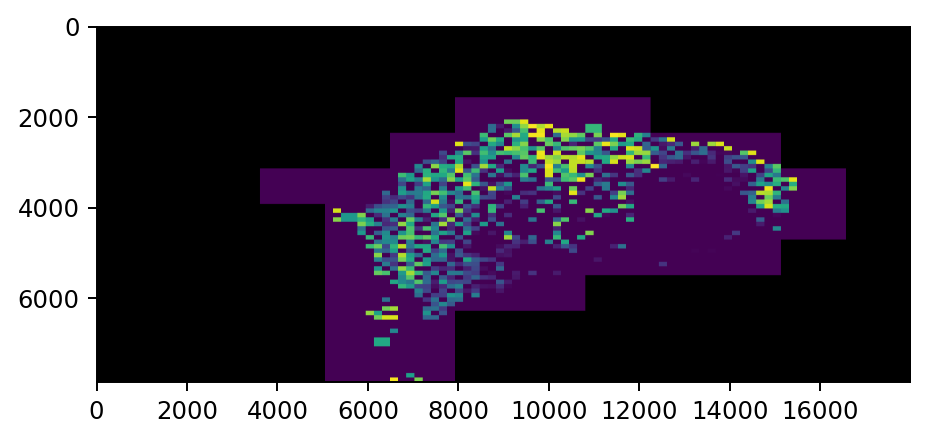

In [42]:
import scipy
tr = scipy.ndimage.rotate(demo_image,-90)
plt.imshow(tr)

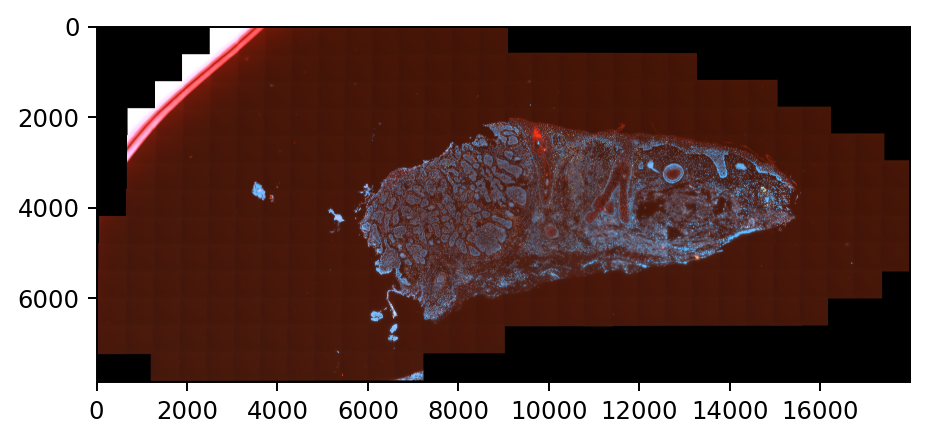

In [43]:
ref = scipy.ndimage.rotate(img_all_origin,-90)
plt.imshow(ref)

In [13]:
test_json = list_output_files[0]
print(test_json)
df_json2 = convert_json2dataframe(test_json)
col_names = df_json2.columns
print(col_names)
# df_json[['Nucleus: Perimeter', 'Cell: Perimeter','Nucleus: Cy5 mean',  'Cell: Cy5 mean', 'Cytoplasm: Cy5 mean']]

/QRISdata/Q1851/Minh/RNAScope/QuPath_project_1/Scene_4/Cy5/measurement_values_Cy5_annot_block_x0_y7435.json
Index(['Name', 'ROI', 'Centroid X', 'Centroid Y', 'Nucleus: Area',
       'Nucleus: Perimeter', 'Nucleus: Circularity', 'Nucleus: Max caliper',
       'Nucleus: Min caliper', 'Nucleus: Eccentricity', 'Nucleus: Cy7 mean',
       'Nucleus: Cy7 sum', 'Nucleus: Cy7 std dev', 'Nucleus: Cy7 max',
       'Nucleus: Cy7 min', 'Nucleus: Cy7 range', 'Nucleus: Cy5 mean',
       'Nucleus: Cy5 sum', 'Nucleus: Cy5 std dev', 'Nucleus: Cy5 max',
       'Nucleus: Cy5 min', 'Nucleus: Cy5 range', 'Nucleus: Cy3 mean',
       'Nucleus: Cy3 sum', 'Nucleus: Cy3 std dev', 'Nucleus: Cy3 max',
       'Nucleus: Cy3 min', 'Nucleus: Cy3 range', 'Nucleus: FITC mean',
       'Nucleus: FITC sum', 'Nucleus: FITC std dev', 'Nucleus: FITC max',
       'Nucleus: FITC min', 'Nucleus: FITC range', 'Nucleus: DAPI mean',
       'Nucleus: DAPI sum', 'Nucleus: DAPI std dev', 'Nucleus: DAPI max',
       'Nucleus: DAPI min'

In [18]:

# df_json = convert_json2dataframe(test_json)
df_json = convert_json2dataframe('/QRISdata/Q1851/Minh/RNAScope/QuPath_project_1/Scene_4/Cy5/x13884_y7435/measurement_values_Cy5_annot_block_x14751_y7806.json',col_names)
df_json.head()

,Name,ROI,Centroid X,Centroid Y,Nucleus: Area,Nucleus: Perimeter,Nucleus: Circularity,Nucleus: Max caliper,Nucleus: Min caliper,Nucleus: Eccentricity,...,Cytoplasm: Cy3 min,Cytoplasm: FITC mean,Cytoplasm: FITC std dev,Cytoplasm: FITC max,Cytoplasm: FITC min,Cytoplasm: DAPI mean,Cytoplasm: DAPI std dev,Cytoplasm: DAPI max,Cytoplasm: DAPI min,Nucleus/Cell area ratio


In [82]:
df_json['Cell: Cy5 mean'].tolist()

[]

In [15]:
def convert_json2dataframe(fn, col_names = list()):
    with open(fn) as json_file:
        json_values = json.load(json_file)
#     print(col_names)
    if len(json_values) != 0:
        try:
            measure_values, row_name = parse_measurement_string(json_values[0])
        except:
            print(fn)
            1/0
        for element in json_values[1:]:
            frame, keys = parse_measurement_string(element)
            measure_values = measure_values.append(frame, ignore_index=True)
        return measure_values
    else:
        if len(col_names) == 0:
            raise Exception("No value found", fn)
        else:
            measure_values = pd.DataFrame(columns= col_names)
            return measure_values

In [19]:
# // Thy1, NM_001311160.2, T2 channel -> Cy3  (orange)
# // IL34, NM_001172771.2, T3 channel -> Cy5 (far red)
# // CSF1R, NM_001288705.2, T4 channel -> Cy7 (near Infrared)
scene1_output_dir = os.path.join(qupath_output, 'Scene_1')
list_output_files_s1 = get_files_in_dir_recursively(scene1_output_dir)
print(len(list_output_files_s1))
list_output_files_s1 = np.array(list_output_files_s1)
s1_cy3 = list()
s1_cy5 = list()
s1_cy7 = list()
s1_dapi = list()
# Nucleus: DAPI mean
for fn in list_output_files_s1:
    if 'Cy3' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s1_cy3.extend(df_json['Cell: Cy3 mean'].tolist())
    elif 'Cy5' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s1_cy5.extend(df_json['Cell: Cy5 mean'].tolist())
    elif 'Cy7' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s1_cy7.extend(df_json['Cell: Cy7 mean'].tolist())
    elif 'DAPI' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s1_dapi.extend(df_json['Nucleus: DAPI mean'].tolist())
print(len(s1_cy3), len(s1_cy5), len(s1_cy7), len(s1_dapi))


9432
4400 5061 18941 37922


In [20]:
scene2_output_dir = os.path.join(qupath_output, 'Scene_2')
list_output_files_s2 = get_files_in_dir_recursively(scene2_output_dir)
print(len(list_output_files_s2))
list_output_files_s2 = np.array(list_output_files_s2)
s2_cy3 = list()
s2_cy5 = list()
s2_cy7 = list()
s2_cell = list()
s2_dapi = list()
# Nucleus: DAPI mean
for fn in list_output_files_s2:
    if 'Cy3' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s2_cy3.extend(df_json['Cell: Cy3 mean'].tolist())
    elif 'Cy5' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s2_cy5.extend(df_json['Cell: Cy5 mean'].tolist())
    elif 'Cy7' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s2_cy7.extend(df_json['Cell: Cy7 mean'].tolist())
    elif 'DAPI' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s2_dapi.extend(df_json['Nucleus: DAPI mean'].tolist())
print(len(s2_cy3), len(s2_cy5), len(s2_cy7), len(s2_dapi))

9204
4652 5217 6089 31923


In [21]:
scene3_output_dir = os.path.join(qupath_output, 'Scene_3')
list_output_files_s3 = get_files_in_dir_recursively(scene3_output_dir)
print(len(list_output_files_s3))
list_output_files_s3 = np.array(list_output_files_s3)
s3_cy3 = list()
s3_cy5 = list()
s3_cy7 = list()
s3_dapi = list()
for fn in list_output_files_s3:
    if 'Cy3' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s3_cy3.extend(df_json['Cell: Cy3 mean'].tolist())
    elif 'Cy5' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s3_cy5.extend(df_json['Cell: Cy5 mean'].tolist())
    elif 'Cy7' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s3_cy7.extend(df_json['Cell: Cy7 mean'].tolist())
    elif 'DAPI' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s3_dapi.extend(df_json['Nucleus: DAPI mean'].tolist())
print(len(s3_cy3), len(s3_cy5), len(s3_cy7), len(s3_dapi))

3868
834 2054 2139 6893


In [22]:
scene4_output_dir = os.path.join(qupath_output, 'Scene_4')
list_output_files_s4 = get_files_in_dir_recursively(scene4_output_dir)
print(len(list_output_files_s4))
list_output_files_s4 = np.array(list_output_files_s4)
s4_cy3 = list()
s4_cy5 = list()
s4_cy7 = list()
s4_dapi = list()
for fn in list_output_files_s4:
    if 'Cy3' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s4_cy3.extend(df_json['Cell: Cy3 mean'].tolist())
    elif 'Cy5' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s4_cy5.extend(df_json['Cell: Cy5 mean'].tolist())
    elif 'Cy7' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s4_cy7.extend(df_json['Cell: Cy7 mean'].tolist())
    elif 'DAPI' in fn:
        df_json = convert_json2dataframe(fn, col_names)
        s4_dapi.extend(df_json['Nucleus: DAPI mean'].tolist())
print(len(s4_cy3), len(s4_cy5), len(s4_cy7), len(s4_dapi))

6800
3271 4965 4396 22769


In [28]:
print(len(s1_cy3), len(s1_cy5), len(s1_cy7))
print(len(s2_cy3), len(s2_cy5), len(s2_cy7))
print(len(s3_cy3), len(s3_cy5), len(s3_cy7))
print(np.array(s1_cy3).min(), np.array(s1_cy3).max())
print(np.array(s1_cy5).min(), np.array(s1_cy5).max())
print(np.array(s1_cy7).min(), np.array(s1_cy7).max())
print(np.array(s2_cy3).min(), np.array(s2_cy3).max())
print(np.array(s2_cy5).min(), np.array(s2_cy5).max())
print(np.array(s2_cy7).min(), np.array(s2_cy7).max())
print(np.array(s3_cy3).min(), np.array(s3_cy3).max())
print(np.array(s3_cy5).min(), np.array(s3_cy5).max())
print(np.array(s3_cy7).min(), np.array(s3_cy7).max())
print(np.array(s4_cy3).min(), np.array(s4_cy3).max())
print(np.array(s4_cy5).min(), np.array(s4_cy5).max())
print(np.array(s4_cy7).min(), np.array(s4_cy7).max())

4400 5061 18941
4652 5217 6089
834 2054 2139
157.2437286376953 950.562744140625
155.22222900390625 1061.3359375
144.1167449951172 935.9225463867188
156.2916717529297 14271.490234375
160.80555725097656 4827.74560546875
150.03846740722656 808.3448486328125
153.4949188232422 820.4690551757812
161.97158813476562 493.9226379394531
149.30555725097656 1083.6788330078125
154.83636474609375 806.7761840820312
163.287353515625 1296.412353515625
151.80555725097656 958.0765380859375


In [165]:
mean_s1_cy3 = np.average(np.array(s1_cy3))
mean_s1_cy5 = np.average(np.array(s1_cy5))
mean_s1_cy7 = np.average(np.array(s1_cy7))
mean_s2_cy3 = np.average(np.array(s2_cy3))
mean_s2_cy5 = np.average(np.array(s2_cy5))
mean_s2_cy7 = np.average(np.array(s2_cy7))
mean_s3_cy3 = np.average(np.array(s3_cy3))
mean_s3_cy5 = np.average(np.array(s3_cy5))
mean_s3_cy7 = np.average(np.array(s3_cy7))
mean_s4_cy3 = np.average(np.array(s4_cy3))
mean_s4_cy5 = np.average(np.array(s4_cy5))
mean_s4_cy7 = np.average(np.array(s4_cy7))


(247.54483190709894, 253.0926873460476, 240.21284559876514, 220.3360917439194)
(247.21898946383686, 247.21898946383686, 199.96083415773387, 269.4644449193672)
(217.24015143166739, 215.11425655200225, 230.68283897852888, 216.14317405082835)


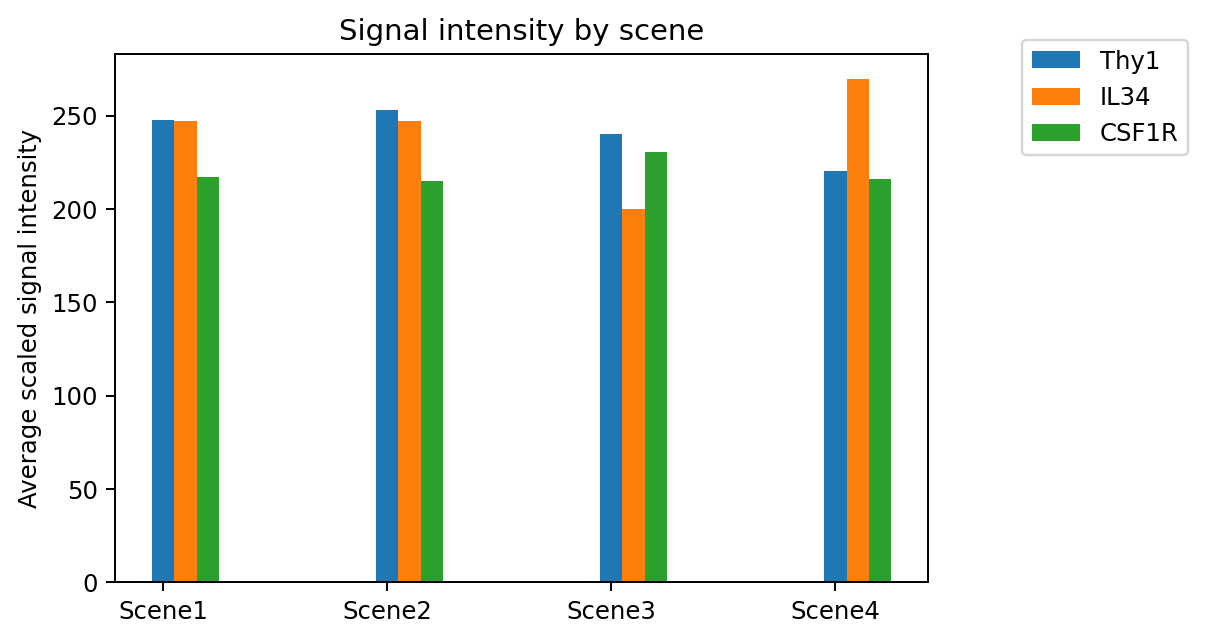

In [170]:
scene1_values = (mean_s1_cy3, mean_s2_cy3, mean_s3_cy3, mean_s4_cy3)
scene2_values = (mean_s2_cy5, mean_s2_cy5, mean_s3_cy5, mean_s4_cy5)
scene3_values = (mean_s1_cy7, mean_s2_cy7, mean_s3_cy7, mean_s4_cy7)
print(scene1_values)
print(scene2_values)
print(scene3_values)
ind = np.arange(len(scene1_values))  # the x locations for the groups
width = 0.1  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind , scene1_values, width,
                label='Thy1')
rects2 = ax.bar(ind + width, scene2_values, width,
                label='IL34')
rect3 = ax.bar(ind + 2*width, scene3_values, width,
                label='CSF1R')

ax.set_ylabel('Average scaled signal intensity')
ax.set_title('Signal intensity by scene')
ax.set_xticks(ind)
ax.set_xticklabels(('Scene1', 'Scene2', 'Scene3', 'Scene4'))
ax.legend(bbox_to_anchor=(1.1, 1.05))



# fig.tight_layout()

plt.show()

(4400, 4652, 834, 3271)
(5061, 5217, 2054, 4965)
(18941, 6089, 2139, 4396)
(37922, 31923, 6893, 22769)


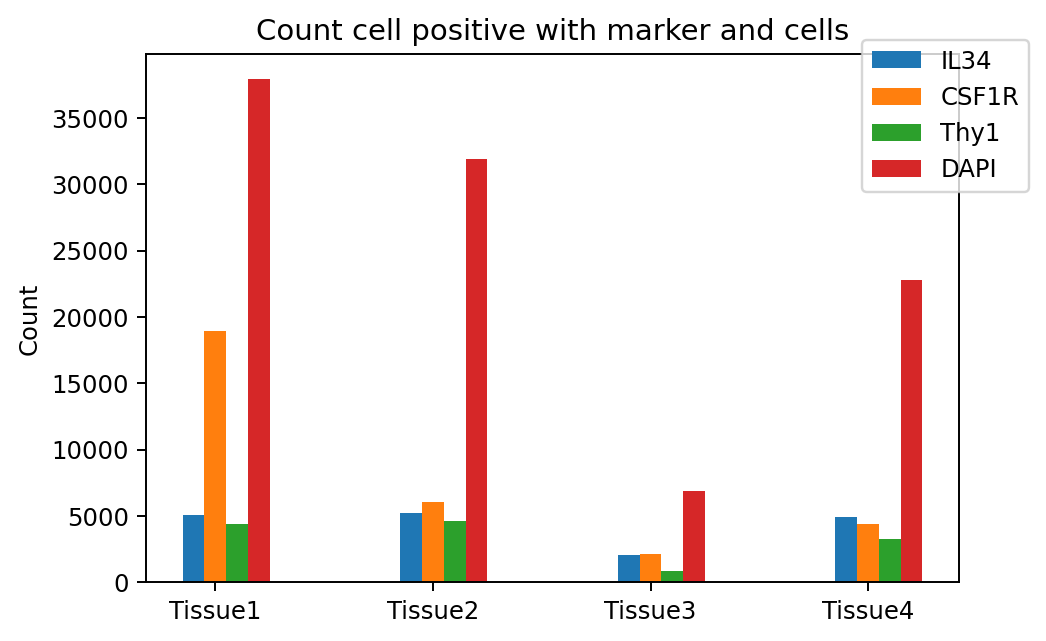

In [33]:
# len(s4_cy3), len(s4_cy5), len(s4_cy7), len(s4_dapi)
col1_values = (len(s1_cy3), len(s2_cy3), len(s3_cy3), len(s4_cy3))
col2_values = (len(s1_cy5), len(s2_cy5), len(s3_cy5), len(s4_cy5))
col3_values = (len(s1_cy7), len(s2_cy7), len(s3_cy7), len(s4_cy7))
col4_values = (len(s1_dapi), len(s2_dapi), len(s3_dapi), len(s4_dapi))
print(col1_values)
print(col2_values)
print(col3_values)
print(col4_values)
ind = np.arange(len(col1_values))  # the x locations for the groups
width = 0.1  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind -width, col2_values, width,
                label='IL34')
rects2 = ax.bar(ind - 0, col3_values, width,
                label='CSF1R')
rect3 = ax.bar(ind + width, col1_values, width,
                label='Thy1')
rect4 = ax.bar(ind + 2*width, col4_values, width,
                label='DAPI')

ax.set_ylabel('Count')
ax.set_title('Count cell positive with marker and cells')
ax.set_xticks(ind)
ax.set_xticklabels(('Tissue1', 'Tissue2', 'Tissue3', 'Tissue4'))
ax.legend(bbox_to_anchor=(1.1, 1.05))

(0.11602763567322398, 0.14572565235096951, 0.1209923110401857, 0.1436602397997277)
(0.13345815094140603, 0.1634244901794944, 0.2979834614826636, 0.21805964249637666)
(0.4994726016560308, 0.19074021865112928, 0.310314812128246, 0.19306952435328736)


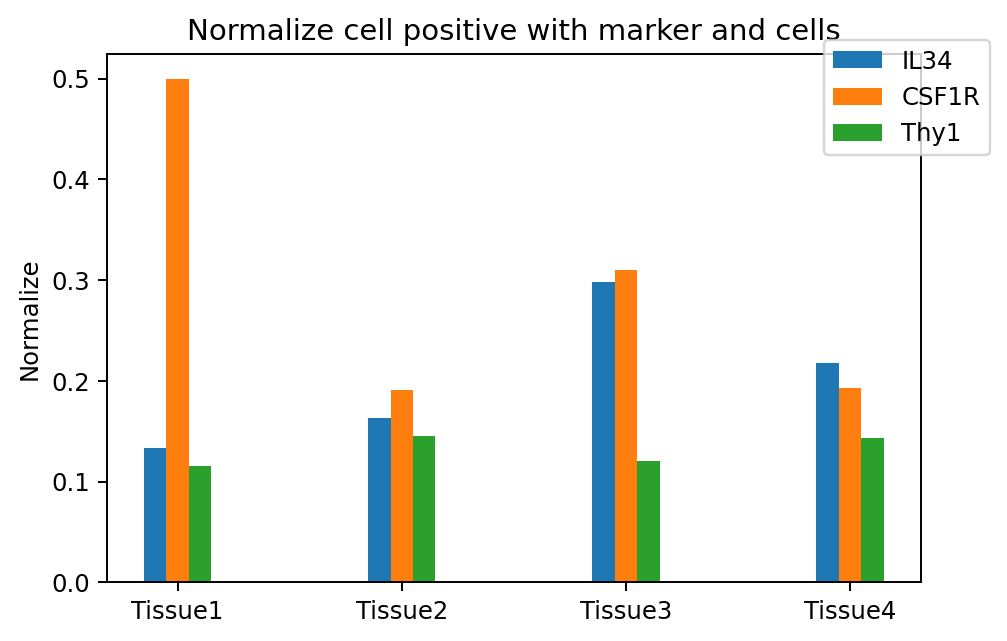

In [34]:
# len(s4_cy3), len(s4_cy5), len(s4_cy7), len(s4_dapi)
col1_values = (len(s1_cy3)/len(s1_dapi), len(s2_cy3)/len(s2_dapi), len(s3_cy3)/len(s3_dapi), len(s4_cy3)/len(s4_dapi))
col2_values = (len(s1_cy5)/len(s1_dapi), len(s2_cy5)/len(s2_dapi), len(s3_cy5)/len(s3_dapi), len(s4_cy5)/len(s4_dapi))
col3_values = (len(s1_cy7)/len(s1_dapi), len(s2_cy7)/len(s2_dapi), len(s3_cy7)/len(s3_dapi), len(s4_cy7)/len(s4_dapi))
# col4_values = (len(s1_dapi), len(s2_dapi), len(s3len(s1_dapi)_dapi), len(s4_dapi))
print(col1_values)
print(col2_values)
print(col3_values)
# print(col4_values)
ind = np.arange(len(col1_values))  # the x locations for the groups
width = 0.1  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind -width, col2_values, width,
                label='IL34')
rects2 = ax.bar(ind - 0, col3_values, width,
                label='CSF1R')
rect3 = ax.bar(ind + width, col1_values, width,
                label='Thy1')
# rect4 = ax.bar(ind + 2*width, col4_values, width,
#                 label='DAPI')

ax.set_ylabel('Normalized')
ax.set_title('Normalized cell positive with marker and cells')
ax.set_xticks(ind)
ax.set_xticklabels(('Tissue1', 'Tissue2', 'Tissue3', 'Tissue4'))
ax.legend(bbox_to_anchor=(1.1, 1.05))